In [ ]:
import numpy as np # linear algebra
import matplotlib.pylab as plt

import pandas as pd # data processing
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

plt.rcParams["figure.figsize"] = (16,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot")

In [ ]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving 3.csv to 3.csv
Saving 2.csv to 2.csv
Saving 1.csv to 1.csv
Saving 0.csv to 0.csv


In [ ]:
df0 = pd.read_csv("./0.csv", header=None )
print(df0.index)
df1 = pd.read_csv("./1.csv", header=None )
df2 = pd.read_csv("./2.csv", header=None )
df3 = pd.read_csv("./3.csv", header=None )
df = pd.concat([df0,df1,df2,df3], axis = 0)
# df.head()
print(df.shape)
df = df.sample(frac=1).reset_index(drop=True)
print(df.index)

RangeIndex(start=0, stop=2910, step=1)
(11678, 65)
RangeIndex(start=0, stop=11678, step=1)


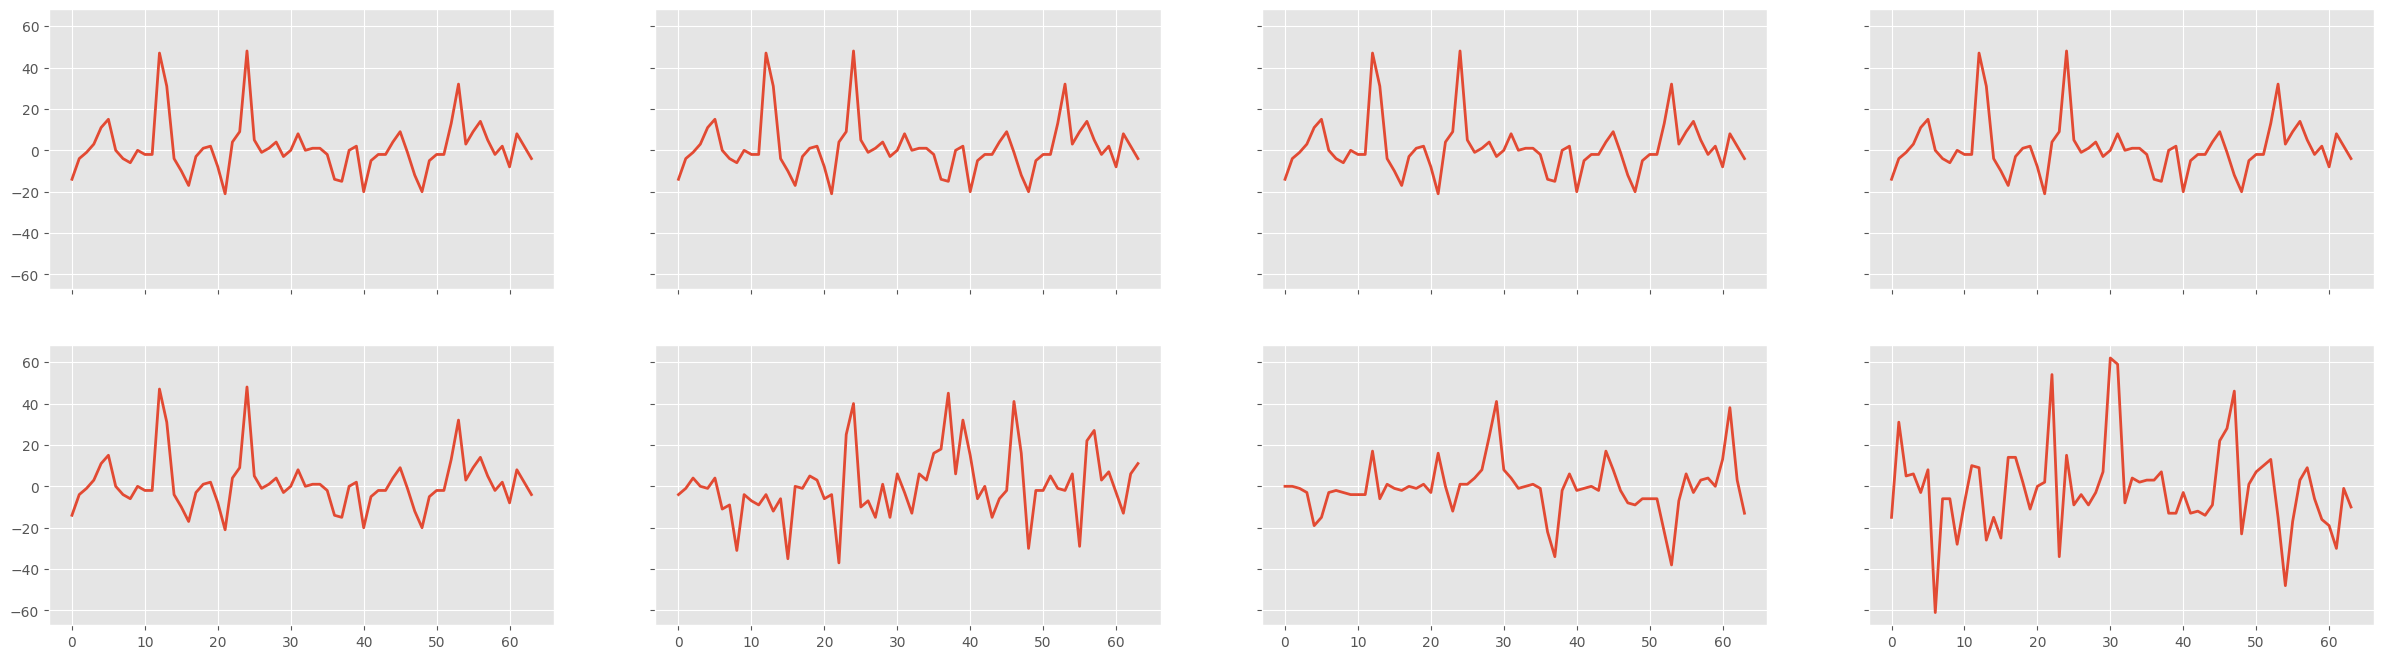

In [ ]:
def plot_data(data):
    fig, axes = plt.subplots(2,4, figsize=(30, 8), sharex=True, sharey=True) # ensures that all subplots share the same x-axis and y-axis
    for i in range(2):
        for j in range(4):
            axes[i][j].plot(data.iloc[i*j])

plot_data(df.loc[:,0:63])


# rock = 0,
# scissors = 1
# paper = 2,
# ok =3.

In [ ]:
x = df.loc[:,0:63]
y = df[64]

In [ ]:
y.unique()

array([1, 0, 3, 2])

In [ ]:
print("All Data size X and y")
print(x.shape)
print(y.shape)

All Data size X and y
(11678, 64)
(11678,)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42,stratify=y)

In [ ]:
print("All Data size X and y")
print(x_train.shape)
print(y_train.shape)

All Data size X and y
(9342, 64)
(9342,)


In [ ]:
print("Test Data size X and y")
print(x_test.shape)
print(y_test.shape)

Test Data size X and y
(2336, 64)
(2336,)


In [ ]:
!pip install network
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for network: filename=network-0.1-py3-none-any.whl size=3140 sha256=9c8c16786a09b65ddd5fdaca25897632659751d72a1f9877d633ba41a02a74b7
  Stored in directory: /root/.cache/pip/wheels/25/97/b1/563d3a70ed8f588bf9cf448f079024a9751b54d15a0ce3d46b
Successfully built network


In [ ]:
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import math
from torch.nn import init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn, optim
import torch
import utils
import network
import argparse
import torch.nn.utils
from pathlib import Path

In [ ]:
class coRNNCell(nn.Module):
    def __init__(self, n_inp, n_hid, dt, gamma, epsilon):
        super(coRNNCell, self).__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        self.i2h = nn.Linear(n_inp + n_hid + n_hid, n_hid)

    def forward(self,x,hy,hz):
        hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((x, hz, hy),1)))
                                   - self.gamma * hy - self.epsilon * hz)
        hy = hy + self.dt * hz

        return hy, hz

class coRNN(nn.Module):
    def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
        super(coRNN, self).__init__()
        self.n_hid = n_hid
        self.cell = coRNNCell(n_inp,n_hid,dt,gamma,epsilon)
        self.readout = nn.Linear(n_hid, n_out)

    def forward(self, x):
        ## initialize hidden states
        hy = Variable(torch.zeros(x.size(1),self.n_hid)).to(device)
        hz = Variable(torch.zeros(x.size(1),self.n_hid)).to(device)
        # print(hy.shape)
        for t in range(x.size(0)):
            hy, hz = self.cell(x[t],hy,hz)
        output = self.readout(hy)

        return output

In [ ]:
class coRNNCell(nn.Module):
    def __init__(self, n_inp, n_hid, dt, gamma, epsilon):
        super(coRNNCell, self).__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        self.i2h = nn.Sequential(
            nn.Linear(n_inp + n_hid + n_hid, n_hid),
            # Add more layers as needed
            # nn.ReLU(),  # Example of adding a ReLU activation layer
            # nn.Linear(n_hid, n_hid),  # Another linear layer
        )

    def forward(self,x,hy,hz):
        hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((x, hz, hy),1)))
                                   - self.gamma * hy - self.epsilon * hz)
        hy = hy + self.dt * hz

        return hy, hz

class coRNN(nn.Module):
    def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
        super(coRNN, self).__init__()
        self.n_hid = n_hid
        self.cell = coRNNCell(n_inp,n_hid,dt,gamma,epsilon)
        self.readout = nn.Linear(n_hid, n_out)

    def forward(self, x):
        ## initialize hidden states
        hy = Variable(torch.zeros(x.size(1),self.n_hid)).to(device)
        hz = Variable(torch.zeros(x.size(1),self.n_hid)).to(device)
        # print(hy.shape)
        for t in range(x.size(0)):
            hy, hz = self.cell(x[t],hy,hz)
        output = self.readout(hy)

        return output

In [ ]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Assuming y_train is categorical (int)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)    # Assuming y_test is categorical (int)
print(y_train_tensor.shape)
# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
total_length = len(train_dataset)
train_length = int(0.8 * total_length)  # 80% for training
valid_length = total_length - train_length  # Remaining for validation

# Use the calculated lengths in random_split
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_length, valid_length])
# Create DataLoader instances
batch_size = 32  # You can adjust this based on your preference
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([9342])


In [ ]:
args = {"n_hid":128,
      "epochs" : 30,
      "batch":50,
      "batch_test":1000,
      "lr":2e-2,
      "dt":6e-2,
      "gamma":66,
      "epsilon":15}

In [ ]:
# n_inp = input_size = x.shape[1]
n_inp = 1
# print(n_inp)
n_out = 4
model = coRNN(n_inp, args['n_hid'], n_out,args['dt'], args['gamma'], args['epsilon'])
# model1 = lstm(n_inp, args['n_hid'], n_out)
# train_loader, valid_loader, test_loader = get_data(args['batch'],1000)
# model.summary()

In [ ]:
def binary_accuracy(preds, y):
    # print(preds.shape)
    rounded_preds = torch.argmax(torch.sigmoid(preds),axis=1)
    # print(rounded_preds.shape)
    # print(y.shape)
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def test(dataloader, model):
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.permute(1, 0)
            data = data.reshape(data.shape[0], data.shape[1], 1)
            predictions = model(data)
            acc = binary_accuracy(predictions, labels)
            epoch_acc += acc
    accuracy = epoch_acc / len(dataloader)
    return accuracy * 100

In [ ]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

In [33]:
best_valid_accuracy = 0.0
best_model_state_dict = None

for epoch in range(args['epochs']):
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        data = data.permute(1, 0)
        optimizer.zero_grad()
        data = data.reshape(data.shape[0], data.shape[1], 1)
        output = model(data)
        # print(output.shape)
        # print(labels.shape)
        loss = objective(output, labels)
        loss.backward()
        optimizer.step()

    eval_acc = test(valid_loader, model)
    print(epoch, 'Valid set: Accuracy: {:.2f}%\n'.format(eval_acc))

    # Save the model checkpoint if the current validation accuracy is better
    if eval_acc > best_valid_accuracy:
        best_valid_accuracy = eval_acc
        best_model_state_dict = model.state_dict()
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        print(best_valid_accuracy)

# Load the best model for testing
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)

# Test the model
test_acc = test(test_loader, model)
print('Test set:  Accuracy: {:.2f}%\n'.format(test_acc))


0 Valid set: Accuracy: 86.73%

tensor(86.7340)
1 Valid set: Accuracy: 84.56%

2 Valid set: Accuracy: 86.79%

tensor(86.7870)
3 Valid set: Accuracy: 87.18%

tensor(87.1822)
4 Valid set: Accuracy: 86.71%

5 Valid set: Accuracy: 86.92%

6 Valid set: Accuracy: 88.64%

tensor(88.6408)
7 Valid set: Accuracy: 87.58%

8 Valid set: Accuracy: 91.29%

tensor(91.2891)
9 Valid set: Accuracy: 88.30%

10 Valid set: Accuracy: 65.64%

11 Valid set: Accuracy: 82.57%

12 Valid set: Accuracy: 88.14%

13 Valid set: Accuracy: 87.50%

14 Valid set: Accuracy: 89.59%

15 Valid set: Accuracy: 87.90%

16 Valid set: Accuracy: 90.62%

17 Valid set: Accuracy: 87.08%

18 Valid set: Accuracy: 88.25%

19 Valid set: Accuracy: 89.35%

20 Valid set: Accuracy: 84.41%

21 Valid set: Accuracy: 85.10%

22 Valid set: Accuracy: 89.60%

23 Valid set: Accuracy: 89.70%

24 Valid set: Accuracy: 78.48%

25 Valid set: Accuracy: 82.72%

26 Valid set: Accuracy: 86.79%

27 Valid set: Accuracy: 88.40%

28 Valid set: Accuracy: 86.68%

29

In [ ]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
x_test = np.array(x_test)
print(x_test.shape)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
print(x_test_tensor.shape)
# Make sure to move the tensor to the appropriate device if you're using GPU
x_test_tensor = x_test_tensor.to(device)
x_test_tensor = x_test_tensor.permute(1,0)
print(x_test_tensor.shape)
x_test_tensor = x_test_tensor.reshape(x_test_tensor.shape[0],x_test_tensor.shape[1],1)


# Assuming model is your PyTorch model
model.eval()  # Set the model to evaluation mode

# Forward pass
with torch.no_grad():
    Y_pred = model(x_test_tensor)
    print(Y_pred.shape)
# Convert predictions classes to one-hot vectors
Y_pred_classes = torch.argmax(torch.sigmoid(Y_pred),axis=1)

(2336, 64)
torch.Size([2336, 64])
torch.Size([64, 2336])
torch.Size([2336, 4])


In [ ]:
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)
# plot the confusion matrix

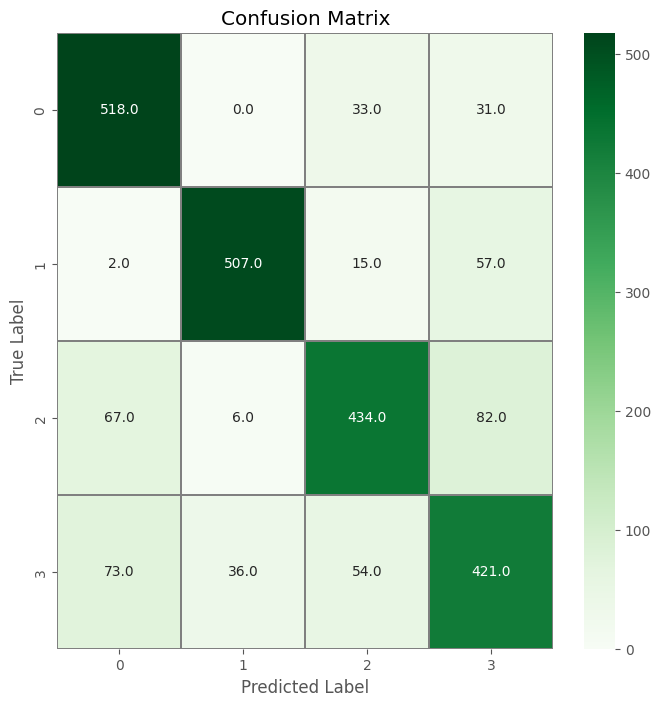

In [ ]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       582
           1       0.91      0.91      0.91       581
           2       0.81      0.79      0.80       589
           3       0.82      0.78      0.80       584

    accuracy                           0.84      2336
   macro avg       0.84      0.84      0.84      2336
weighted avg       0.84      0.84      0.84      2336

